In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=496df33c0815765e8e6506f743046b675d7ca3ab2417173f8d7e6a051907e62e
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
#import necessary libraries
import numpy as np
import pandas as pd
import re
import os
import heapq
#import wikipedia
from tqdm.auto import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk import PorterStemmer
ps = PorterStemmer()
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#namrata's google drive path
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/CS 247 Project/ml-100k"


Mounted at /content/drive


In [ ]:
#reading data in from MovieLens
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv(path + '/u.item', sep='|', names=i_cols,encoding='latin-1')
items = pd.DataFrame(items)

#users
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path + "/u.user", sep='|', names=u_cols,
encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)

#ratings
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv(path + '/u.data', sep='\t', names=r_cols, encoding='latin-1')

ratings_base = pd.read_csv(path + '/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv(path + '/ua.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base
rate_test = ratings_test
#print(ratings_base[0:20])

print('Number of traing rates:', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of users: 943
Number of traing rates: 90570
Number of test rates: 9430


737


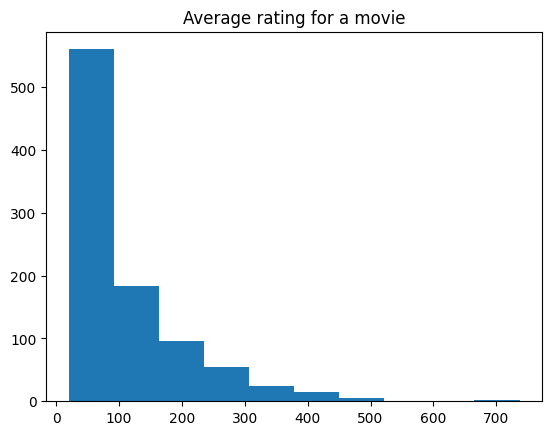

In [ ]:
#avg rating for a movie
import matplotlib.pyplot as plt
avg = ratings.groupby("user_id").count()['rating']

print((max(avg)))


In [ ]:
#get the movie plots and concatenate them to the items dataset

def get_wikipedia_page_name(raw_name):
    print(raw_name)
    names = wikipedia.search(raw_name)
    if len(names) == 0:
      return ''
    else:
      return names[0]

def get_movie_plot(raw_name):
    names = wikipedia.search(raw_name)
    if len(names) == 0:
      page_name= ''
    else:
      page_name = names[0]
    print(page_name)

    try:
      try:
        movie_page_content = str(wikipedia.page(page_name, auto_suggest=False).content)
      except wikipedia.DisambiguationError as e:
        for option in e.options:
          if 'film' in option:
            movie_page_content = str(wikipedia.page(option, auto_suggest=False).content)
        return ''
    except (wikipedia.PageError, KeyError):
      return ''
    re_groups = re.search("Plot ==(.*?)=+ [A-Z]", str(movie_page_content).replace('\n', ''))
    if re_groups:
      return re_groups.group(1)
    else:
      return ''


#items['wikipedia_page_name'] = items['movie title'].apply(lambda name: get_wikipedia_page_name(name))
i = 0
name = path + '/plot.csv'
if os.path.exists(name):
  movies_df = pd.read_csv(name)
else:
  items['movie_plot'] = items['movie title'].apply(lambda name: get_movie_plot(name))
  items[['movie title', 'movie_plot']].head()
  items.to_csv(name)

In [ ]:
movies_df["movie_plot"].isna().sum(), movies_df.shape


(310, (1682, 26))

In [ ]:
#drop movies that have NaN plots. Remove those movie ratings from ratings matrix too
movies_df = movies_df[~pd.isna(movies_df['movie_plot'])]
ratings_base = ratings_base[ratings_base['movie_id'].isin(movies_df.index)]
ratings_test = ratings_test[ratings_test['movie_id'].isin(movies_df.index)]
ratings = ratings[ratings['movie_id'].isin(movies_df['movie id'])]
#ratings = ratings.drop(columns=['unix_timestamp'])

In [ ]:
movies_df.shape[0]

1372

In [ ]:
movies_df.tail()

,Unnamed: 0,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_plot
1674,1674,1675,"Sunchaser, The (1996)",25-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Sunchaser,%20...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Brandon ""Blue"" Monroe, a 16-year-old half-Nava..."
1675,1675,1676,"War at Home, The (1996)",01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?War%20at%20Ho...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Jeremy Collier is a returning Vietnam War hero...
1677,1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"The film opens on two human forms, which soon ..."
1678,1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,...,0,0,0,0,1,0,1,0,0,Alan (Jared Harris) is a schoolteacher in Lond...
1679,1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,...,0,0,0,0,1,0,0,0,0,Helen Quilley gets fired from her public relat...


In [ ]:
movies_df.shape[0]

1372

In [ ]:
#VERY IMPORTANT!!!

index = [i for i in range(movies_df.shape[0])]
movies_df.index = index

In [ ]:
movies_df

,Unnamed: 0,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_plot
0,0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"Sentient when humans are not around, a group o..."
1,1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,...,0,0,0,0,0,0,1,0,0,"In 1986, MI6 agents James Bond and Alec Trevel..."
2,2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"Ernesto ""Chili"" Palmer is a Miami-based loan s..."
4,4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,...,0,0,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1674,1675,"Sunchaser, The (1996)",25-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Sunchaser,%20...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Brandon ""Blue"" Monroe, a 16-year-old half-Nava..."
1368,1675,1676,"War at Home, The (1996)",01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?War%20at%20Ho...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Jeremy Collier is a returning Vietnam War hero...
1369,1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"The film opens on two human forms, which soon ..."
1370,1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,...,0,0,0,0,1,0,1,0,0,Alan (Jared Harris) is a schoolteacher in Lond...


In [ ]:
#convert one hot encoding genres to text

#convert to numpy array
cols = movies_df.columns
for i in range(movies_df.shape[0]):

  df_array = movies_df.iloc[i].to_numpy()
  #print(df_array)
  col_indices = np.where(df_array == 1)[0]
  col_indices = col_indices[col_indices > 3]
  #print(' '.join(list(np.take(cols, list(col_indices)))))
  movies_df.at[i, 'genres'] = ' '.join(list(np.take(cols, list(col_indices))))



In [ ]:
movies_df

,Unnamed: 0,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres
0,0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,0,0,"Sentient when humans are not around, a group o...",Animation Children's Comedy
1,1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,...,0,0,0,0,0,1,0,0,"In 1986, MI6 agents James Bond and Alec Trevel...",Action Adventure Thriller
2,2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,...,0,0,0,0,0,1,0,0,"On New Year's Eve, bellhop Sam (Marc Lawrence)...",Thriller
3,3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,...,0,0,0,0,0,0,0,0,"Ernesto ""Chili"" Palmer is a Miami-based loan s...",Action Comedy Drama
4,4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,...,0,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,Crime Drama Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1674,1675,"Sunchaser, The (1996)",25-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Sunchaser,%20...",0,0,0,0,...,0,0,0,0,0,0,0,0,"Brandon ""Blue"" Monroe, a 16-year-old half-Nava...",Drama
1368,1675,1676,"War at Home, The (1996)",01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?War%20at%20Ho...,0,0,0,0,...,0,0,0,0,0,0,0,0,Jeremy Collier is a returning Vietnam War hero...,Drama
1369,1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,...,0,0,0,0,0,0,0,0,"The film opens on two human forms, which soon ...",Drama
1370,1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,...,0,0,0,1,0,1,0,0,Alan (Jared Harris) is a schoolteacher in Lond...,Romance Thriller


In [ ]:
movies_df.isna().sum()

Unnamed: 0               0
movie id                 0
movie title              0
release date             0
video release date    1372
IMDb URL                 0
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
movie_plot               0
genres                   0
dtype: int64

In [ ]:
movies_df.shape

(1372, 27)

In [ ]:
#convert release data to just year
d = movies_df.iloc[0]['release date']
date = d.split('-')[2]
date
def date_to_year(date_string):
  year = date_string.split('-')[2]
  print(year)
  return year

movies_df['release date'] = movies_df['release date'].apply(date_to_year)
print(date_to_year("06-Feb-1998"))


In [ ]:
#preprocess the plots

def preprocess_sentences(sentence):
  text = str(sentence).lower()
  temp_sent =[]
  words = nltk.word_tokenize(text)
  for word in words:
    if word not in stop_words and word.isalpha():
        temp_sent.append(word)

  stemmed = [ps.stem(word) for word in temp_sent]
  stemmed = " ".join(stemmed)
  return stemmed

movies_df['processed_plot'] = movies_df['movie_plot'].apply(preprocess_sentences)
#construct tags column
movies_df['keywords'] = movies_df['release date'] + " " + movies_df['genres'] + " " + movies_df['processed_plot']
movies_df.head()

,Unnamed: 0,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres,processed_plot,keywords
0,0,1,Toy Story (1995),1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,"Sentient when humans are not around, a group o...",Animation Children's Comedy,sentient human around group toy prepar move ne...,1995 Animation Children's Comedy sentient huma...
1,1,2,GoldenEye (1995),1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,...,0,0,0,1,0,0,"In 1986, MI6 agents James Bond and Alec Trevel...",Action Adventure Thriller,agent jame bond alec trevelyan infiltr soviet ...,1995 Action Adventure Thriller agent jame bond...
2,2,3,Four Rooms (1995),1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,...,0,0,0,1,0,0,"On New Year's Eve, bellhop Sam (Marc Lawrence)...",Thriller,new year eve bellhop sam marc lawrenc hotel mo...,1995 Thriller new year eve bellhop sam marc la...
3,3,4,Get Shorty (1995),1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,...,0,0,0,0,0,0,"Ernesto ""Chili"" Palmer is a Miami-based loan s...",Action Comedy Drama,ernesto chili palmer loan shark movi buff leat...,1995 Action Comedy Drama ernesto chili palmer ...
4,4,5,Copycat (1995),1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,...,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,Crime Drama Thriller,give guest lectur crimin psycholog local unive...,1995 Crime Drama Thriller give guest lectur cr...


In [ ]:
movies_df = movies_df.drop(['video release date','IMDb URL', 'Unnamed: 0'], axis=1)


In [ ]:
movies_df.shape

(1372, 26)

In [ ]:
movies_df.tail()

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres,processed_plot,keywords
1367,1675,"Sunchaser, The (1996)",1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"Brandon ""Blue"" Monroe, a 16-year-old half-Nava...",Drama,brandon blue monro gang member east serv time ...,1996 Drama brandon blue monro gang member east...
1368,1676,"War at Home, The (1996)",1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,Jeremy Collier is a returning Vietnam War hero...,Drama,jeremi collier return vietnam war hero whose e...,1996 Drama jeremi collier return vietnam war h...
1369,1678,Mat' i syn (1997),1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,"The film opens on two human forms, which soon ...",Drama,film open two human form soon reveal young man...,1998 Drama film open two human form soon revea...
1370,1679,B. Monkey (1998),1998,0,0,0,0,0,0,0,...,0,1,0,1,0,0,Alan (Jared Harris) is a schoolteacher in Lond...,Romance Thriller,alan jare harri schoolteach london also moonli...,1998 Romance Thriller alan jare harri schoolte...
1371,1680,Sliding Doors (1998),1998,0,0,0,0,0,0,0,...,0,1,0,0,0,0,Helen Quilley gets fired from her public relat...,Drama Romance,helen quilley get fire public relat job leav o...,1998 Drama Romance helen quilley get fire publ...


In [ ]:
movies_df.to_csv("drive/My Drive/CS 247 Project/movies_with_plots.csv")

In [ ]:
#create corpus for Word2Vec

corpus = ["hi"]
for sentence in movies_df['keywords']:
  #print(corpus)
  corpus.extend(str(sentence).split())

print(corpus[0:4])
unique_corpus = list(set(corpus)) #corpus of all unique words in the keywords

['hi', '1995', 'Animation', "Children's"]


In [ ]:
ratings_base.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
#drop unix_timeestamp column
ratings_base = ratings_base.drop(columns=['unix_timestamp'])

#Expand the ratings_base table by using pivot

all_ratings = ratings_base.pivot(index="user_id", columns="movie_id", values="rating").fillna(0)


In [ ]:
all_ratings.shape

(943, 1370)

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

In [ ]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
#apply SVD
from numpy.linalg import svd
matrix = all_ratings.values
u_svd, s, v_svd = svd(matrix, full_matrices=False, compute_uv=True)

In [ ]:
v_svd.shape, u_svd.shape, s.shape

((943, 1370), (943, 943), (943,))

In [ ]:
ratings.head()

,user_id,movie_id,rating
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4


In [ ]:
#Creating user profiles
#get the top 5 ratings of the users to create the embedding

#checking the minimum number of ratings per user

ratings_base.shape
ratings_base.drop_duplicates()

grouped_by_users = ratings_base.groupby('user_id').count()
sorted(grouped_by_users['rating'])

def create_user_profile(user_id):
  user_ratings = ratings_base[ratings_base['user_id'] == user_id]
  top_ratings = user_ratings.sort_values(by=['rating'])[:5]
  #get movie_ids of the top ratings and get those embedding vectors

  #avg the embedding vectors




In [ ]:
#evaluation using Hits, Recall, Precision

class Evaluation():

  def evaluate_for_user(user_id):
    #Hits@K: for given user, check if test set contains movies that appear in top K recommendations. Sum for all users
    #Precision@K: for each user, calculate positive recommendations / K
    #Recall@K: for each user, calculate positive recommendations / test set size for user
    test_set = ""
    test_set_for_user = test_set[test_set['user_id'] == user_id]
    recommendations_for_user = recommendation_of_movies(user_id, user_profile, k)
    hit = int(any(x in recommendations_for_user['movie_id'] for x in test_set_for_user['movie_id']))
    precision = 0 #change
    recall = 0
    metrics = {"hit": hit, "precision": precision, "recall": recall}

  def get_average_metrics():
    all_users = test_set['user_id']
    hits = 0
    precision = 0
    recall = 0
    for user_id in all_users:
      user_metrics = evaluate_for_user(user_id)
      hits.append





In [ ]:
len(movies_df)

1576

Word2Vec embeddings generation




In [ ]:
movies_df = pd.read_csv("drive/My Drive/CS 247 Project/movies_with_plots.csv")

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api


# Fill missing values in the 'keywords' column
movies_df['keywords'].fillna('', inplace=True)

# Tokenize content for Word2Vec
movies_df['tokenized_content'] = movies_df['keywords'].apply(lambda x: simple_preprocess(x) if isinstance(x, str) else [])

# Load the pre-trained Word2Vec model (Google News)
model = api.load('word2vec-google-news-300')

# Function to average word vectors for a text
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Function to compute average word vectors for all movies
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# Compute average word vectors for all movies
w2v_feature_array = averaged_word_vectorizer(corpus=movies_df['tokenized_content'], model=model, num_features=300)

# Create a dictionary to map movie titles to their indices
title_to_index = {title: i for i, title in enumerate(movies_df['movie title'])}


print(title_to_index['Toy Story (1995)'])  # This will print the index of the movie 'Toy Story (1995)'


[==================================================] 100.0% 1662.8/1662.8MB downloaded
0


In [ ]:
print(w2v_feature_array.shape)
w2v = pd.DataFrame(w2v_feature_array)
w2v.head()
w2v.to_csv("drive/MyDrive/CS 247 Project/w2v_original_300.csv")

(1372, 300)


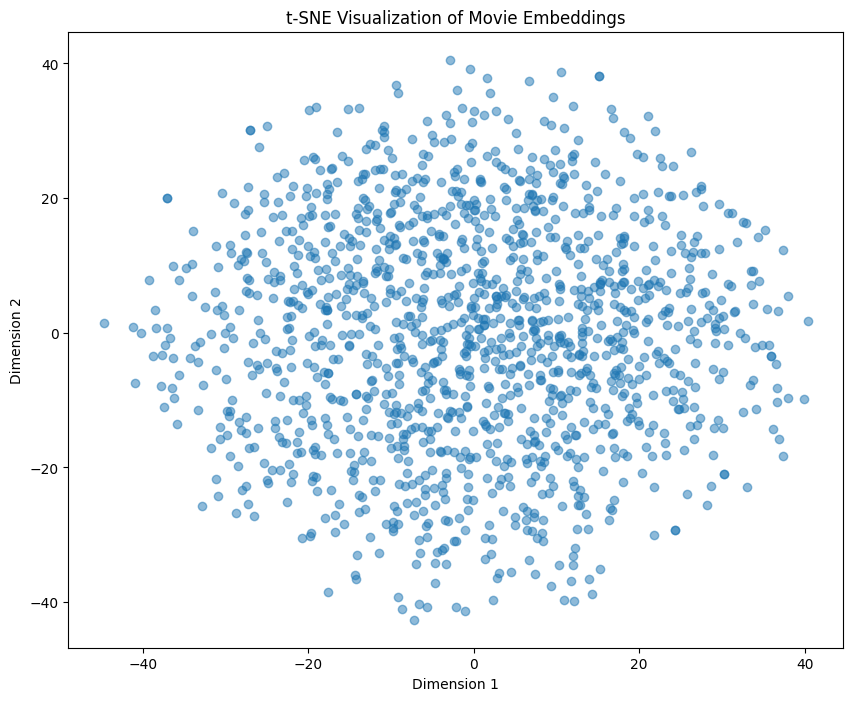

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(w2v_feature_array)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Movie Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


PCA To reduce embedding dimensionality

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
movies_df.shape

(1372, 29)

In [ ]:
#IMPORTANT: add movie_inner_id as unique id column

arr = np.array([i for i in range(len(movies_df))])
movies_df['movie_inner_id'] = arr
movies_df.head()

,Unnamed: 0,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres,processed_plot,keywords,movie_inner_id
0,0,1,Toy Story (1995),1995,0,0,0,1,1,1,...,0,0,0,0,0,"Sentient when humans are not around, a group o...",Animation Children's Comedy,sentient human around group toy prepar move ne...,1995 Animation Children's Comedy sentient huma...,0
1,1,2,GoldenEye (1995),1995,0,1,1,0,0,0,...,0,0,1,0,0,"In 1986, MI6 agents James Bond and Alec Trevel...",Action Adventure Thriller,agent jame bond alec trevelyan infiltr soviet ...,1995 Action Adventure Thriller agent jame bond...,1
2,2,3,Four Rooms (1995),1995,0,0,0,0,0,0,...,0,0,1,0,0,"On New Year's Eve, bellhop Sam (Marc Lawrence)...",Thriller,new year eve bellhop sam marc lawrenc hotel mo...,1995 Thriller new year eve bellhop sam marc la...,2
3,3,4,Get Shorty (1995),1995,0,1,0,0,0,1,...,0,0,0,0,0,"Ernesto ""Chili"" Palmer is a Miami-based loan s...",Action Comedy Drama,ernesto chili palmer loan shark movi buff leat...,1995 Action Comedy Drama ernesto chili palmer ...,3
4,4,5,Copycat (1995),1995,0,0,0,0,0,0,...,0,0,1,0,0,After giving a guest lecture on criminal psych...,Crime Drama Thriller,give guest lectur crimin psycholog local unive...,1995 Crime Drama Thriller give guest lectur cr...,4


In [ ]:
movies_df.shape

(1372, 29)

In [ ]:
#reduce word2vec

w2v_embeds = pd.read_csv("drive/MyDrive/CS 247 Project/w2v_original_300.csv")
print(w2v_embeds.shape)
w2v_embeds.head()

(1372, 301)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,0.032440,0.048701,-0.005005,0.042696,-0.050156,-0.054397,0.014686,-0.077388,0.059069,...,-0.035557,0.070100,-0.083479,-0.001838,-0.002970,-0.059603,-0.032524,-0.024494,-0.025383,-0.001334
1,1,0.015813,0.039240,0.024548,0.039506,-0.077720,0.008955,0.002863,-0.055493,0.093870,...,-0.025416,0.056034,-0.061051,0.037879,-0.051991,-0.020429,-0.061661,-0.068386,-0.007421,-0.008707
2,2,0.034581,0.068824,-0.015137,0.079019,-0.045505,-0.026404,-0.015824,-0.085004,0.082596,...,0.015390,0.061670,-0.085029,0.006955,-0.009737,-0.093524,-0.081972,-0.054405,-0.064113,0.055393
3,3,-0.022465,0.018711,0.007557,0.089649,-0.019290,0.027685,0.029826,-0.090367,0.038400,...,0.007054,0.048938,-0.073528,0.064517,0.027207,-0.033590,-0.006148,-0.057124,-0.018980,0.021270
4,4,0.003922,0.041028,0.031716,0.084410,-0.045528,0.013961,0.006702,-0.051039,0.081234,...,-0.002676,0.036621,-0.072990,0.059270,-0.068709,-0.067961,-0.033695,-0.085545,-0.028245,0.045481


In [ ]:
w2v_embeds = w2v_embeds.drop(columns=['Unnamed: 0'])

In [ ]:
w2v_embeds.tail()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1367,-0.000554,0.066557,0.028908,0.083175,-0.034481,-0.028783,0.008848,-0.118723,0.049550,0.071020,...,0.008825,0.043300,-0.076519,0.041396,-0.062847,-0.043971,-0.058078,-0.051290,0.013930,0.000393
1368,0.023790,0.056228,0.013404,0.098833,-0.043285,0.012498,0.072310,-0.108272,0.066007,0.035603,...,-0.087063,0.025769,-0.083834,0.006691,-0.063657,-0.034707,-0.024933,-0.052522,0.056953,0.037429
1369,0.048349,0.039057,-0.014289,0.076053,-0.039666,-0.008467,0.046379,-0.121751,0.090226,0.091047,...,-0.058099,0.024647,-0.090506,-0.049379,-0.024277,-0.004231,-0.011892,-0.033882,0.006904,-0.002228
1370,-0.033464,0.029251,-0.021767,0.100225,-0.035579,-0.004983,-0.016137,-0.053573,0.026594,0.065779,...,0.002201,0.060226,-0.076756,0.009327,-0.058339,-0.061075,-0.018519,-0.097040,-0.034648,0.015528
1371,-0.004896,0.018641,-0.002652,0.086615,-0.040483,-0.004169,0.012600,-0.096017,0.071158,0.057850,...,0.001440,0.059999,-0.080300,-0.018942,-0.076169,-0.090968,-0.026978,-0.014094,0.008586,0.020773


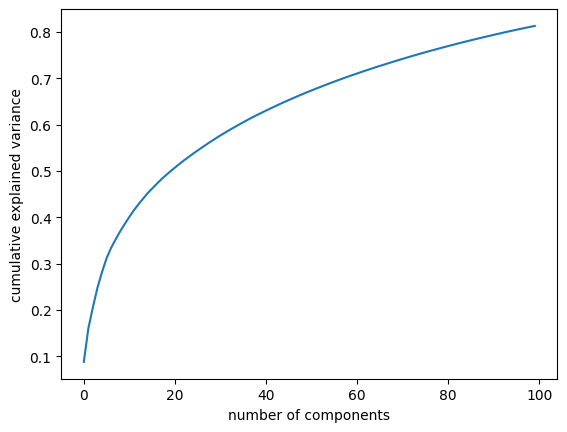

In [ ]:
#pca
pca_w2v = PCA(n_components=100)
reduced_w2v = pca_w2v.fit_transform(w2v_embeds)

#visualise the explained variance ratio

plt.plot(np.cumsum(pca_w2v.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
reduced_w2v = pd.DataFrame(reduced_w2v)
reduced_w2v.to_csv("drive/MyDrive/CS 247 Project/reduced_w2v_100.csv")
reduced_w2v.head(), reduced_w2v.shape


(         0         1         2         3         4         5         6   \
 0  0.044352 -0.096595 -0.058203 -0.058613 -0.079985  0.132220  0.038677   
 1  0.135025 -0.241918  0.075546 -0.031238  0.083857 -0.026193 -0.011173   
 2 -0.301201  0.057210  0.205297 -0.051806  0.016447  0.275891  0.093323   
 3 -0.055351 -0.079481 -0.032807 -0.010591  0.010239  0.072230  0.003647   
 4 -0.022096 -0.135770  0.004978  0.066896  0.116491 -0.000526  0.142088   
 
          7         8         9   ...        90        91        92        93  \
 0 -0.006038 -0.065343 -0.060582  ... -0.042037  0.058978 -0.005276 -0.030791   
 1 -0.052311 -0.016045 -0.026773  ... -0.020282  0.018422  0.001800  0.015268   
 2 -0.017713 -0.124219  0.015175  ... -0.035673 -0.002207  0.000441  0.023738   
 3  0.032966 -0.130691  0.006907  ... -0.011475 -0.026128 -0.033603 -0.016158   
 4  0.020643  0.042621 -0.025336  ...  0.003309 -0.007363 -0.011903  0.016649   
 
          94        95        96        97        98  

In [ ]:
#reduced_embeds = pd.read_csv("drive/MyDrive/CS 247 Project/reduced_bert.csv")
reduced_embeds = reduced_w2v

arr = np.array([i for i in range(len(movies_df))])
reduced_embeds['movie_inner_id'] = arr
cols = reduced_embeds.columns.tolist()
cols = cols[-1:] + cols[:-1]
reduced_embeds = reduced_embeds[cols]

reduced_embeds.to_csv("drive/MyDrive/CS 247 Project/movieid_w2v_100.csv")

In [ ]:
reduced_embeds.shape, reduced_embeds.head()

((1372, 101),
    movie_inner_id         0         1         2         3         4         5  \
 0               0  0.044352 -0.096595 -0.058203 -0.058613 -0.079985  0.132220   
 1               1  0.135025 -0.241918  0.075546 -0.031238  0.083857 -0.026193   
 2               2 -0.301201  0.057210  0.205297 -0.051806  0.016447  0.275891   
 3               3 -0.055351 -0.079481 -0.032807 -0.010591  0.010239  0.072230   
 4               4 -0.022096 -0.135770  0.004978  0.066896  0.116491 -0.000526   
 
           6         7         8  ...        90        91        92        93  \
 0  0.038677 -0.006038 -0.065343  ... -0.042037  0.058978 -0.005276 -0.030791   
 1 -0.011173 -0.052311 -0.016045  ... -0.020282  0.018422  0.001800  0.015268   
 2  0.093323 -0.017713 -0.124219  ... -0.035673 -0.002207  0.000441  0.023738   
 3  0.003647  0.032966 -0.130691  ... -0.011475 -0.026128 -0.033603 -0.016158   
 4  0.142088  0.020643  0.042621  ...  0.003309 -0.007363 -0.011903  0.016649   
 
    

In [ ]:
folder_path = "drive/MyDrive/CS 247 Project/10th_March_BERT_movie_embeddings.csv"
bert_embeddings = pd.read_csv(folder_path, header=None)
bert_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.354938,0.055294,0.535662,0.016911,0.257760,-0.031973,0.036531,-0.045506,-0.099130,-0.229953,...,-0.390960,-0.341942,0.103260,0.160311,0.009635,0.003835,-0.624504,-0.005162,0.161328,-0.002070
1,-0.350013,-0.047078,0.474593,-0.066661,0.460981,-0.058233,0.155333,0.111255,-0.017857,-0.250210,...,-0.397488,-0.213463,0.094989,0.061074,0.026851,-0.179708,-0.546885,-0.108441,0.050433,0.146390
2,-0.021004,-0.077059,0.325559,0.195044,0.044663,0.007157,-0.012687,0.014451,0.020503,0.077981,...,0.020842,-0.126572,0.153138,-0.059947,0.094046,0.117395,0.009193,0.127859,0.134761,0.164424
3,0.032292,-0.029772,0.567799,-0.175749,0.454340,-0.003125,0.005940,0.011646,0.101402,-0.309613,...,-0.364782,-0.450121,0.135068,0.172036,-0.117097,0.011439,-0.707874,-0.096183,-0.042957,-0.095156
4,-0.362471,0.036806,0.513014,-0.122374,0.360396,0.076607,0.121204,-0.021013,-0.003072,-0.299811,...,-0.401280,-0.321970,0.053093,0.139898,-0.210887,0.088246,-0.433998,-0.141566,-0.008733,0.028656


In [ ]:
len(bert_embeddings)

1372

In [ ]:
pca_bert = PCA(n_components=300)
reduced_embs = pca_bert.fit_transform(bert_embeddings)

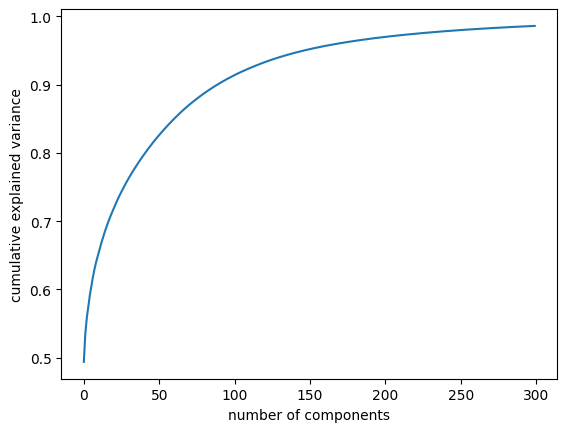

In [ ]:
#visualise the explained variance ratio

plt.plot(np.cumsum(pca_bert.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
reduced_embeddings = pd.DataFrame(reduced_embs)

In [ ]:
reduced_embeddings.head(), reduced_embeddings.shape

(        0         1         2         3         4         5         6    \
 0 -0.832738 -0.215074  0.347622 -0.637940  0.749081 -0.349148  0.056785   
 1 -1.341698  1.629674  0.042430  0.086045 -0.129394 -0.555819  0.706938   
 2  5.429399  1.385329 -0.097708 -0.076707  1.319640 -0.118385 -0.096060   
 3 -1.424625 -0.833726  1.036436  0.355735  0.291084 -0.359851 -0.231848   
 4 -0.312232  0.339018  0.604763  0.400713 -0.615663  0.020199  0.088661   
 
         7         8         9    ...       290       291       292       293  \
 0  0.167086 -0.703274  0.452534  ...  0.035519 -0.020190  0.014588 -0.050765   
 1  0.050253  0.323971  0.018559  ...  0.013141 -0.044769  0.037007 -0.021662   
 2  1.056974 -0.762405  0.200421  ...  0.001075 -0.015087 -0.052423 -0.051647   
 3  0.540400 -0.508264  0.495955  ... -0.060226  0.052180 -0.011440  0.022730   
 4 -0.072559 -0.544776 -0.041252  ...  0.010882 -0.006909  0.015252 -0.004810   
 
         294       295       296       297       298  

In [ ]:
reduced_embeddings.to_csv("drive/MyDrive/CS 247 Project/reduced_bert_100.csv")

In [ ]:
reduced_embeddings.shape, movies_df.shape

((1372, 300), (1372, 28))

In [ ]:
#reduced_embeds = pd.read_csv("drive/MyDrive/CS 247 Project/reduced_bert.csv")
reduced_embeds = reduced_embeddings

arr = np.array([i for i in range(len(movies_df))])
reduced_embeds['movie_inner_id'] = arr
cols = reduced_embeds.columns.tolist()
cols = cols[-1:] + cols[:-1]
reduced_embeds = reduced_embeds[cols]

#reduced_embeds.to_csv("drive/MyDrive/CS 247 Project/movieid_bert_100.csv")

In [ ]:
reduced_embeds


,movie_inner_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,-0.832738,-0.215074,0.347622,-0.637940,0.749081,-0.349148,0.056785,0.167086,-0.703274,...,0.035519,-0.020190,0.014588,-0.050765,0.036667,-0.033171,0.001195,-0.018493,-0.002712,-0.025460
1,1,-1.341698,1.629674,0.042430,0.086045,-0.129394,-0.555819,0.706938,0.050253,0.323971,...,0.013141,-0.044769,0.037007,-0.021662,0.039157,-0.004886,-0.013238,0.009502,0.024327,0.020551
2,2,5.429399,1.385329,-0.097708,-0.076707,1.319640,-0.118385,-0.096060,1.056974,-0.762405,...,0.001075,-0.015087,-0.052423,-0.051647,-0.046060,0.022055,0.062438,-0.026410,-0.014263,-0.034665
3,3,-1.424625,-0.833726,1.036436,0.355735,0.291084,-0.359851,-0.231848,0.540400,-0.508264,...,-0.060226,0.052180,-0.011440,0.022730,-0.020972,0.018542,0.109261,0.019409,0.033502,0.037364
4,4,-0.312232,0.339018,0.604763,0.400713,-0.615663,0.020199,0.088661,-0.072559,-0.544776,...,0.010882,-0.006909,0.015252,-0.004810,-0.031749,-0.010764,0.007000,-0.009742,-0.047384,-0.020260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1367,0.676591,0.265226,0.244031,-0.519665,0.040395,0.059998,0.042063,-0.140188,0.171902,...,-0.049289,-0.013630,0.018558,0.003654,0.021049,0.002258,-0.003421,0.011062,0.042565,-0.000883
1368,1368,4.058698,-0.408721,0.108924,0.022884,-0.312680,-0.462640,0.083774,-0.291438,0.307971,...,0.021136,0.032635,0.057617,-0.059884,0.049423,-0.040301,0.016656,-0.013707,0.021790,0.036390
1369,1369,3.289943,-0.354229,-0.554306,-0.752881,-0.385706,0.945230,0.543655,-0.039310,-0.088156,...,0.025665,0.005987,0.026190,-0.035468,0.041427,-0.045517,-0.043930,0.015257,0.040378,0.002937
1370,1370,4.790489,0.810977,0.161456,-0.008983,0.306331,0.037846,-0.302907,0.188807,-0.542763,...,0.021300,0.002599,0.058985,0.000044,-0.031526,-0.012970,0.037504,0.032796,-0.074105,0.024648


DeepFM attempt

In [ ]:
movies_df = movies_df.rename(columns={"movie id": "movie_id"})
movies_df.head(1)


,Unnamed: 0,movie_id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres,processed_plot,keywords,movie_inner_id
0,0,1,Toy Story (1995),1995,0,0,0,1,1,1,...,0,0,0,0,0,"Sentient when humans are not around, a group o...",Animation Children's Comedy,sentient human around group toy prepar move ne...,1995 Animation Children's Comedy sentient huma...,0


In [ ]:
movies_df.shape

(1372, 28)

In [ ]:
#merge
result = pd.merge(ratings, movies_df, on="movie_id", how="left")


In [ ]:
ratings.shape
#ratings = ratings.drop(columns=['unix_timestamp'])

(92350, 3)

In [ ]:
result = result[['user_id', 'movie_inner_id', 'rating']]

In [ ]:
result.head()

,user_id,movie_inner_id,rating
0,196,214,3
1,186,269,3
2,22,338,1
3,244,47,2
4,166,309,1


In [ ]:
result.shape, ratings.shape

((92350, 3), (92350, 3))

In [ ]:
result.head(6)

,user_id,movie_inner_id,rating
0,196,214,3
1,186,269,3
2,22,338,1
3,244,47,2
4,166,309,1
5,298,427,4


In [ ]:
movies_df.shape

(1372, 28)

In [ ]:
result.head(6)


,user_id,movie_inner_id,rating
0,196,214,3
1,186,269,3
2,22,338,1
3,244,47,2
4,166,309,1
5,298,427,4


In [ ]:
result[result['movie_inner_id'].isna()]

,user_id,movie_inner_id,rating


In [ ]:
result.isna().sum()

user_id           0
movie_inner_id    0
rating            0
dtype: int64

In [ ]:
#merge ratings with embeddings on movie_inner_id
ratings_embeds = pd.merge(result, reduced_embeds, on="movie_inner_id", how="left")

In [ ]:
ratings_embeds.head()

,user_id,movie_inner_id,rating,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,196,214,3,3.194728,0.061651,-0.331230,0.191145,-0.093588,-0.432737,0.372749,...,0.041445,0.037818,-0.025049,-0.040159,0.028561,0.021271,0.001722,0.001138,0.025352,-0.021368
1,186,269,3,-1.358003,1.141688,-0.213566,0.514465,-0.277339,-0.221666,-0.676820,...,0.020443,0.010443,0.017351,0.002717,-0.003919,-0.008589,0.007353,-0.001100,0.039031,-0.045830
2,22,338,1,-1.751778,0.235083,-0.159816,-0.660811,0.375102,-0.112133,-0.305111,...,0.043479,0.046000,0.004363,-0.016426,-0.004731,-0.047235,-0.042359,-0.013901,0.006247,-0.030025
3,244,47,2,-1.739278,-0.747136,-0.261599,0.292270,-0.327049,0.734472,0.007718,...,0.010090,0.006457,-0.065633,0.036893,-0.056215,0.012515,-0.020107,0.028591,0.051197,0.029971
4,166,309,1,-0.919694,-0.198350,0.724057,0.386660,0.433270,-0.391006,-0.583598,...,0.041760,-0.004850,0.023014,-0.011400,-0.077393,0.000180,0.003119,0.009795,0.029963,-0.017073


In [ ]:
ratings_embeds.shape

(92350, 303)

In [ ]:
any(ratings_embeds.isna().sum())

False